        ## AuxTel LTS-337-015 (Small Slew and Settle)

In this notebook, we check the speed and accuracy of the slew and settle of the telescope with a certain change.  Desired specs:

| Description | Value       | Unit          |   Name     |
| :---        |    :----:   |       :----:  |       ---: |
|The pointing accuracy requirement for small slews is:    | 2.5       | Arcsec RMS   |Aux_Tel_Sm_Slew_Abs_Pointing|
|The small elevation slew requirement for the Auxiliary Telescope used to define the Aux_Tel_Sm_Slew_Abs_Pointing requirement| 10| Degrees |Aux_Tel_Sm_Elev_Slew|
|The small azimuth slew requirement for the Auxiliary Telescope used to define the Aux_Tel_Sm_Slew_Abs_Pointing requirement.  |10       | Degrees     |Aux_Tel_Sm_Az_Slew|
|The allotted time to perform a slew and settle by Aux_Tel_Sm_Elev_Slew and Aux_Tel_Sm_Az_Slew by the Auxiliary Telescope and meet the Aux_Tel_Sm_Slew_Abs_Pointing pointing requirement.      | 10|Seconds|Aux_Tel_Smslew_AcqTime|


Specification: The Auxiliary Telescope shall slew and settle Aux_Tel_Sm_Az_Slew degrees in azimuth and Aux_Tel_Sm_Elev_Slew degrees in elevation in Aux_Tel_Smslew_AcqTime seconds with the maximum RMS pointing error for this repositioning given by Aux_Tel_Sm_Slew_Abs_Pointing. This requirement shall be met with slews originating from any point in the pointing range. The drives of each axis shall be movable simultaneously. The RMS pointing error shall be measured over 1 second immediately following the slew and settle.
Discussion: The Aux_Tel_Sm_Slew_AcqTime second time interval is designed assuming the maximum RMS pointing error requirement shall be met after the first movement, no re-acquisition should be required. 


Included in this notebook are the test and results of several 'small slews' of 10 degrees in elevation and 10 degres in azimuth. The slew and settle acquisition time and pointing accuracy of the slew has been measured. The slews originated from different positions in the pointing range. Results are shown in the Results section below, and also will be saved in a file (Attached AuxTel_LTS-337-015_220408)

This notebook is divided into 4 sections:
1. Notebook and ATCS Setup 
2. Tes
    a. Configuration
    b. Test
    c. Save results
    d. System shutdown
3. Results
    a. Slew Times
    b. Mount position plots
    c. Pointing accuracy 
4. Conclusion. 

# 1. Notebook and System Setup

In [2]:
import sys, time, os, asyncio

from datetime import datetime, date
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lsst.ts import salobj
from lsst.ts.observatory.control.auxtel.atcs import ATCS
from lsst.ts.observatory.control.auxtel.latiss import LATISS

from astropy.time import Time, TimeDelta
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u
from lsst.ts.observatory.control.utils import RotType


from lsst_efd_client import EfdClient
from lsst_efd_client import  __version__ as efdVersion

In [5]:
import logging
stream_handler = logging.StreamHandler(sys.stdout)
logger = logging.getLogger()
logger.addHandler(stream_handler)
logger.level = logging.INFO

In [8]:
# Get EFD client 
print(efdVersion)
client = EfdClient('summit_efd')

__version__ = '0.10.2'


In [4]:
#get classes and start them
domain = salobj.Domain()

In [5]:
atcs = ATCS(domain)
latiss = LATISS(domain)
await asyncio.gather(atcs.start_task, latiss.start_task)

Read historical data in 0.00 sec


Read historical data in 0.02 sec


Read historical data in 0.03 sec


Read historical data in 0.05 sec


Read historical data in 0.06 sec


Read historical data in 0.08 sec


Read historical data in 0.10 sec


Read historical data in 0.11 sec


Read historical data in 0.12 sec


Read historical data in 0.13 sec


Read historical data in 0.15 sec


[[None, None, None, None, None, None, None], [None, None, None, None]]

In [ ]:
# enable components if required
await atcs.enable()
await latiss.enable()

In [ ]:
# Disable Dome following 
await atcs.disable_dome_following()

In [ ]:
# turn on ATAOS corrections just to make sure the mirror 
# is under air
tmp = await atcs.rem.ataos.cmd_enableCorrection.set_start(
    m1=True, hexapod=True, atspectrograph=False)

In [7]:
test_type = 'Small Slew and Settle - LTS-337-015'
filename = 'AuxTel_LTS-337-015_' + date.today().strftime("%y%m%d") + '.txt'

In [9]:
# Enter the filename where to save the results.
with open(filename, 'a') as f:
    f.write(f'{test_type} on {time.asctime()} \n')
    f.write('Start_Time[UTC], End_Time[UTC], Start_Azimuth[deg], ' 
            'Start_Elevation[deg], Slew_Time[s], Start_image, End_image\n')

f.close()

# 2. Test

## Configuration

In [58]:
# Small Slew and Settle - test name and number of iterations. 
number_of_iterations = 1

# Declare Origin Position
origin_az=50
origin_el=35
origin_rot_pa=0

# Declare offset 
delta_az= 10 # degrees
delta_el = -10 # degrees
delta_rot= 0 # degrees

target_az = origin_az + delta_az
target_el = origin_el + delta_el
target_rot = origin_rot_pa + delta_rot

if origin_el not in range(18,86) or target_el not in range(18,86):
    print('Caution: Review origin elevation and/or target elevation configuration')
    
else:
    print(f'This is the {test_type} test \n'
      f'The initial azimuth is {origin_az} degrees \n'
      f'The final azimuth {target_az} degrees \n'
      f'The initial elevation is {origin_el} degrees \n'
      f'The final elevation {target_el} degrees \n'
      f'Results will be saved in {filename}')

This is the Small Slew and Settle - LTS-337-015 test 
The initial azimuth is 50 degrees 
The final azimuth 60 degrees 
The initial elevation is 35 degrees 
The final elevation 25 degrees 
Results will be saved in AuxTel_LTS-337-015_220408.txt


In [59]:
# Find targets
origin_source = await atcs.find_target(origin_az, origin_el, mag_limit=9.0, radius=0.5) 
target_source = await atcs.find_target(target_az, target_el, mag_limit=9.0, radius =0.5)
print(f'The origin source is {origin_source}. The target source is {target_source}')

ra_dec_origin = atcs.radec_from_azel(az = origin_az, el=origin_el)
ra_dec_target = atcs.radec_from_azel(az = target_az, el=target_el)

print(f'Origin source is {origin_source}. Position is AZ {origin_az:0.3f} deg and EL {origin_el:0.3f} deg, ' 
      f'which is RA {ra_dec_origin.ra:0.3f} and DEC {ra_dec_origin.dec:0.3f}')
print(f'Target source is {target_source}. Position is AZ {target_az:0.3f} deg and EL {target_el:0.3f} deg, ' 
      f'which is RA {ra_dec_origin.ra:0.3f} and DEC {ra_dec_target.ra:0.3f}')


The origin source is HD 127853. The target source is HD 137793
Origin source is HD 127853. Position is AZ 50.000 deg and EL 35.000 deg, which is RA 218.454 deg and DEC 9.652 deg
Target source is HD 137793. Position is AZ 60.000 deg and EL 25.000 deg, which is RA 218.454 deg and DEC 231.853 deg


## Test

In [60]:
print('Starting Test')

# Starting test
start_end_pairs = []

n = 0
while n < number_of_iterations: 
    
    await atcs.stop_tracking()

    # Slew to starting position
    print(f'Slew to origin source {origin_source} at RA {ra_dec_origin.ra:0.3f} and '
          f'DEC {ra_dec_origin.dec:0.3f}')

    await atcs.slew_object(origin_source, rot=origin_rot_pa, 
                           rot_type=RotType.PhysicalSky, 
                           slew_timeout=240.)

    print('Track')
    await asyncio.sleep(1)
    
    # A first image to check pointing
    image_origin = await latiss.take_engtest(exptime=3, 
                                                n=1, 
                                                filter='SDSSi',
                                                grating='empty_1')

    # Now slew to target
    print(f'Slew to target source {target_source} at RA {ra_dec_target.ra:0.3f} and '
          f'DEC {ra_dec_target.dec:0.3f}')

    start_time_target = Time(Time.now(), format='fits', scale='utc')

    await atcs.slew_object(target_source, rot=target_rot, 
                           rot_type=RotType.PhysicalSky, 
                           slew_timeout=240.)
    
    end_time_target = Time(Time.now(), format='fits', scale='utc')
    slew_time_target = TimeDelta(end_time_target - start_time_target, 
                                 format='sec').value
    print(f'Time to slew and settle was {slew_time_target:0.3f} seconds')
    
    await asyncio.sleep(1)
    image_target = await latiss.take_engtest(exptime=3, 
                                                n=1, 
                                                filter='SDSSi',
                                                grating='empty_1')
    
    pair_target = [start_time_target, 
                   end_time_target, 
                   round(slew_time_target,3),
                   image_origin, image_target]
    start_end_pairs.append(pair_target)
    

    # Repeat the slew going back to origin position

    print('Slew back to origin')
    start_time_origin = Time(Time.now(), format='fits', scale='utc')
    
    await atcs.slew_object(origin_source, rot=origin_rot_pa, 
                           rot_type=RotType.PhysicalSky, 
                           slew_timeout=240.)


    end_time_origin = Time(Time.now(), format='fits', scale='utc')
    slew_time_origin = TimeDelta(end_time_origin - start_time_origin, 
                                 format='sec').value
    print(f'Time to slew and settle was {slew_time_origin:0.3f} seconds')
    
    await asyncio.sleep(1)
    image_origin2 = await latiss.take_engtest(exptime=3, 
                                                n=1, 
                                                filter='SDSSi',
                                                grating='empty_1')
    
    pair_origin = [start_time_origin, 
                   end_time_origin, 
                   round(slew_time_origin,3),
                  image_target, image_origin2]
    start_end_pairs.append(pair_origin)

    
    n=n+1
    
    

Starting Test
Slew to origin source HD 127853 at RA 218.454 deg and DEC 9.652 deg


Slewing to HD 127853: 14 33 31.0987 +09 12 26.871


Monitor disabled. Enabling and starting monitoring loop.


[Telescope] delta Alt = -000.881 deg; delta Az = -022.011 deg; delta N1 = -000.000 deg; delta N2 = -001.156 deg [Dome] delta Az = -022.941 deg


[Telescope] delta Alt = -000.213 deg; delta Az = -021.762 deg; delta N1 = +000.000 deg; delta N2 = -000.326 deg [Dome] delta Az = -022.291 deg


[Telescope] delta Alt = +000.001 deg; delta Az = -020.584 deg; delta N1 = +000.000 deg; delta N2 = -000.002 deg [Dome] delta Az = -020.731 deg


[Telescope] delta Alt = -000.001 deg; delta Az = -018.241 deg; delta N1 = +000.000 deg; delta N2 = -000.008 deg [Dome] delta Az = -016.681 deg


[Telescope] delta Alt = -000.001 deg; delta Az = -012.994 deg; delta N1 = +000.000 deg; delta N2 = -000.002 deg [Dome] delta Az = -013.271 deg


[Telescope] delta Alt = -000.002 deg; delta Az = -009.025 deg; delta N1 = -000.000 deg; delta N2 = -000.004 deg [Dome] delta Az = -008.621 deg


[Telescope] delta Alt = -000.002 deg; delta Az = -005.352 deg; delta N1 = -000.000 deg; delta N2 = -000.004 deg [Dome] delta Az = -003.221 deg


ATDome in position.


[Telescope] delta Alt = -000.002 deg; delta Az = -002.479 deg; delta N1 = -000.000 deg; delta N2 = -000.004 deg [Dome] delta Az = +000.109 deg


[Telescope] delta Alt = -000.002 deg; delta Az = -000.721 deg; delta N1 = -000.000 deg; delta N2 = -000.004 deg [Dome] delta Az = +000.619 deg


[Telescope] delta Alt = -000.001 deg; delta Az = -000.055 deg; delta N1 = -000.000 deg; delta N2 = -000.009 deg [Dome] delta Az = +000.619 deg


ATMCS in position: True.


[Telescope] delta Alt = -000.001 deg; delta Az = +000.001 deg; delta N1 = -000.000 deg; delta N2 = -000.003 deg [Dome] delta Az = +000.619 deg


Setting monitor flag to false.
Track


[Telescope] delta Alt = -000.001 deg; delta Az = +000.001 deg; delta N1 = -000.000 deg; delta N2 = -000.003 deg [Dome] delta Az = +000.619 deg
Slew to target source HD 137793 at RA 231.853 deg and DEC 10.368 deg


Slewing to HD 137793: 15 27 36.2833 +10 38 45.272


Monitor disabled. Enabling and starting monitoring loop.


ATMCS in position: False.


[Telescope] delta Alt = -010.572 deg; delta Az = +009.523 deg; delta N1 = -000.000 deg; delta N2 = -000.064 deg [Dome] delta Az = +009.807 deg


[Telescope] delta Alt = -008.788 deg; delta Az = +007.813 deg; delta N1 = +000.000 deg; delta N2 = -000.002 deg [Dome] delta Az = +008.697 deg


[Telescope] delta Alt = -005.161 deg; delta Az = +004.126 deg; delta N1 = -000.000 deg; delta N2 = -000.002 deg [Dome] delta Az = +006.917 deg


[Telescope] delta Alt = -001.609 deg; delta Az = +000.896 deg; delta N1 = -000.000 deg; delta N2 = -000.003 deg [Dome] delta Az = +004.207 deg


ATDome in position.


[Telescope] delta Alt = -000.067 deg; delta Az = +000.002 deg; delta N1 = +000.000 deg; delta N2 = -000.003 deg [Dome] delta Az = +002.877 deg


ATMCS in position: True.


[Telescope] delta Alt = +000.000 deg; delta Az = -000.002 deg; delta N1 = +000.000 deg; delta N2 = -000.003 deg [Dome] delta Az = +001.727 deg


[Telescope] delta Alt = -000.002 deg; delta Az = +000.001 deg; delta N1 = +000.000 deg; delta N2 = -000.003 deg [Dome] delta Az = +000.577 deg


Setting monitor flag to false.
Time to slew and settle was 13.848 seconds
Slew back to origin


Slewing to HD 127853: 14 33 31.0987 +09 12 26.871


Monitor disabled. Enabling and starting monitoring loop.


ATMCS in position: False.


[Telescope] delta Alt = +010.566 deg; delta Az = -009.542 deg; delta N1 = +000.000 deg; delta N2 = -000.094 deg [Dome] delta Az = -009.336 deg


[Telescope] delta Alt = +009.891 deg; delta Az = -008.952 deg; delta N1 = -000.000 deg; delta N2 = -000.002 deg [Dome] delta Az = -008.686 deg


[Telescope] delta Alt = +007.058 deg; delta Az = -006.054 deg; delta N1 = -000.000 deg; delta N2 = -000.003 deg [Dome] delta Az = -007.116 deg


[Telescope] delta Alt = +003.184 deg; delta Az = -002.250 deg; delta N1 = -000.000 deg; delta N2 = -000.003 deg [Dome] delta Az = -004.646 deg


ATDome in position.


[Telescope] delta Alt = +000.529 deg; delta Az = -000.164 deg; delta N1 = -000.000 deg; delta N2 = -000.003 deg [Dome] delta Az = -003.176 deg


[Telescope] delta Alt = -000.001 deg; delta Az = +000.000 deg; delta N1 = +000.000 deg; delta N2 = -000.002 deg [Dome] delta Az = -002.026 deg


ATMCS in position: True.


[Telescope] delta Alt = -000.001 deg; delta Az = +000.001 deg; delta N1 = +000.000 deg; delta N2 = -000.003 deg [Dome] delta Az = -000.996 deg


Setting monitor flag to false.
Time to slew and settle was 13.941 seconds


[Telescope] delta Alt = -000.002 deg; delta Az = +000.001 deg; delta N1 = -000.000 deg; delta N2 = -000.004 deg [Dome] delta Az = -000.246 deg


Nothing to check.


## Save results

In [61]:
# Save test results in a file (See file attached)
with open(filename, 'a') as f:
    for item in start_end_pairs:
        f.write(f'{item[0].value},{item[1].value},{origin_az},{origin_el},{item[2]}, '
                f'{item[3]}, {item[4]}\n')
f.close()
print(f'Start/end move times [UTC], slew duration (s), starting azimuth/' 
      f'elevation (deg) and start/end images are saved in {filename}')

Start/end move times [UTC], slew duration (s), starting azimuth/elevation (deg) and start/end images are saved in AuxTel_LTS-337-015_220408.txt


## System Shutdown

In [62]:
# For shutdown of system
await atcs.stop_tracking()

In [ ]:
# turn off corrections
tmp = await atcs.rem.ataos.cmd_disableCorrection.set_start(m1=True, hexapod=True, atspectrograph=True)

In [ ]:
# Putting everything back in standby.
await atcs.shutdown()

# 3. Results 

## Slew Acquisition Times

In [ ]:
# Print results

In [8]:
with open(filename, 'r') as f:
    print(f.read())


Small Slew and Settle - LTS-337-015 on Fri Apr  8 03:14:43 2022 
Start_Time[UTC], End_Time[UTC], Start_Azimuth[deg], Start_Elevation[deg], Slew_Time[s], Start_image, End_image
2022-04-08T03:18:02.303,2022-04-08T03:18:15.651,240,70,13.348, [2022040700286], [2022040700287]
2022-04-08T03:18:22.629,2022-04-08T03:18:35.948,240,70,13.319, [2022040700287], [2022040700288]
2022-04-08T03:19:01.801,2022-04-08T03:19:15.149,240,70,13.348, [2022040700289], [2022040700290]
2022-04-08T03:19:22.231,2022-04-08T03:19:35.545,240,70,13.314, [2022040700290], [2022040700291]
2022-04-08T03:21:25.666,2022-04-08T03:21:39.144,170,50,13.478, [2022040700292], [2022040700293]
2022-04-08T03:21:46.030,2022-04-08T03:21:59.446,170,50,13.415, [2022040700293], [2022040700294]
2022-04-08T03:22:24.872,2022-04-08T03:22:38.248,170,50,13.376, [2022040700295], [2022040700296]
2022-04-08T03:22:45.241,2022-04-08T03:22:58.651,170,50,13.409, [2022040700296], [2022040700297]
2022-04-08T03:24:08.780,2022-04-08T03:24:21.896,150,50,1

In [9]:
# Plots

In [10]:
# import pandas module 
import pandas as pd 
    
# making dataframe 
df = pd.read_csv(filename, skiprows=1, 
                 skipinitialspace=True) 
df

,Start_Time[UTC],End_Time[UTC],Start_Azimuth[deg],Start_Elevation[deg],Slew_Time[s],Start_image,End_image
0,2022-04-08T03:18:02.303,2022-04-08T03:18:15.651,240,70,13.348,[2022040700286],[2022040700287]
1,2022-04-08T03:18:22.629,2022-04-08T03:18:35.948,240,70,13.319,[2022040700287],[2022040700288]
2,2022-04-08T03:19:01.801,2022-04-08T03:19:15.149,240,70,13.348,[2022040700289],[2022040700290]
3,2022-04-08T03:19:22.231,2022-04-08T03:19:35.545,240,70,13.314,[2022040700290],[2022040700291]
4,2022-04-08T03:21:25.666,2022-04-08T03:21:39.144,170,50,13.478,[2022040700292],[2022040700293]
5,2022-04-08T03:21:46.030,2022-04-08T03:21:59.446,170,50,13.415,[2022040700293],[2022040700294]
6,2022-04-08T03:22:24.872,2022-04-08T03:22:38.248,170,50,13.376,[2022040700295],[2022040700296]
7,2022-04-08T03:22:45.241,2022-04-08T03:22:58.651,170,50,13.409,[2022040700296],[2022040700297]
8,2022-04-08T03:24:08.780,2022-04-08T03:24:21.896,150,50,13.116,[2022040700298],[2022040700299]
9,2022-04-08T03:24:28.838,2022-04-08T03:24:41.948,150,50,13.110,[2022040700299],[2022040700300]


Text(0.5, 0, 'Azimuth [deg]')

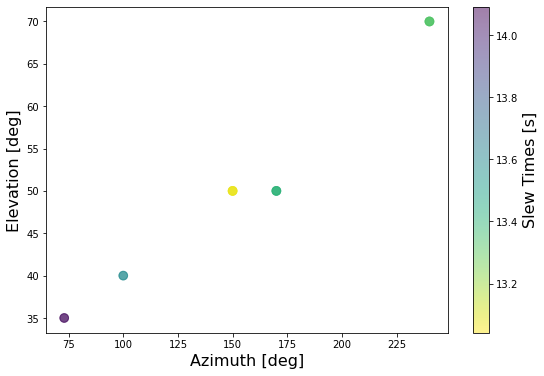

In [8]:
fig = plt.figure(figsize=(9,6))
plt.scatter(df['Start_Azimuth[deg]'], df['Start_Elevation[deg]'], 
            s=75, alpha=0.5, c=df['Slew_time[s]'], label=f'Slew Times', cmap='viridis_r')
plt.colorbar().set_label('Slew Times [s]',fontsize=16)
plt.ylabel('Elevation [deg]',fontsize=16)
plt.xlabel('Azimuth [deg]',fontsize=16)


***

In [21]:
smallSlew_AcqTime = df['Slew_Time[s]'].mean()
smallSlew_AcqTime_min = df['Slew_Time[s]'].min()
print(f'The average time to perform a slew and settle by 10 deg azimuth and 10 deg elevation '
      f'by the Auxiliary Telescope is {smallSlew_AcqTime:0.2f} s.\n '
      f'The shortest time spent in a small slew was {smallSlew_AcqTime_min:0.2f} s')

The average time to perform a slew and settle by 10 deg azimuth and 10 deg elevation by the Auxiliary Telescope is 13.42 s.
 The shortest time spent in a small slew was 13.04 s


***

## Mount position plot

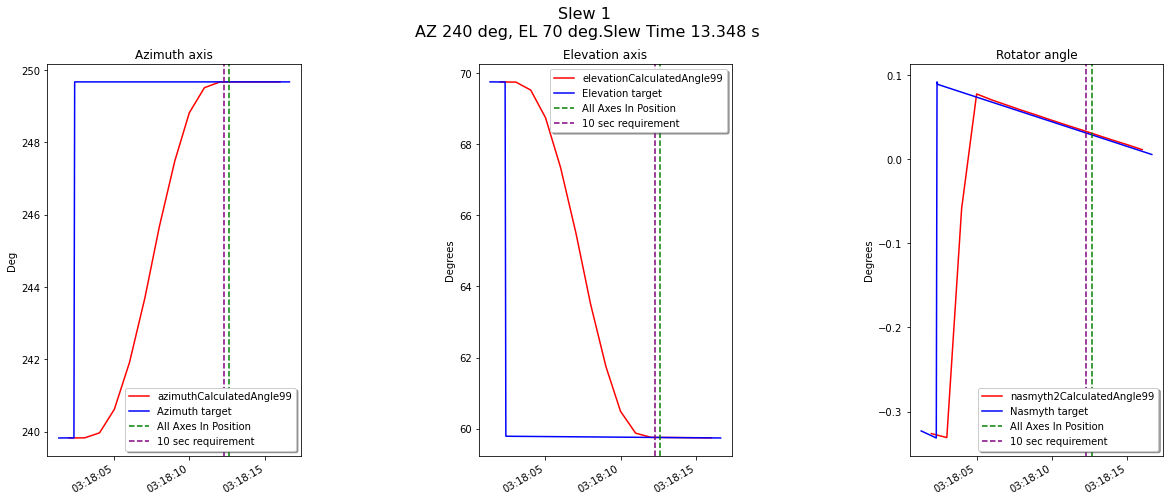

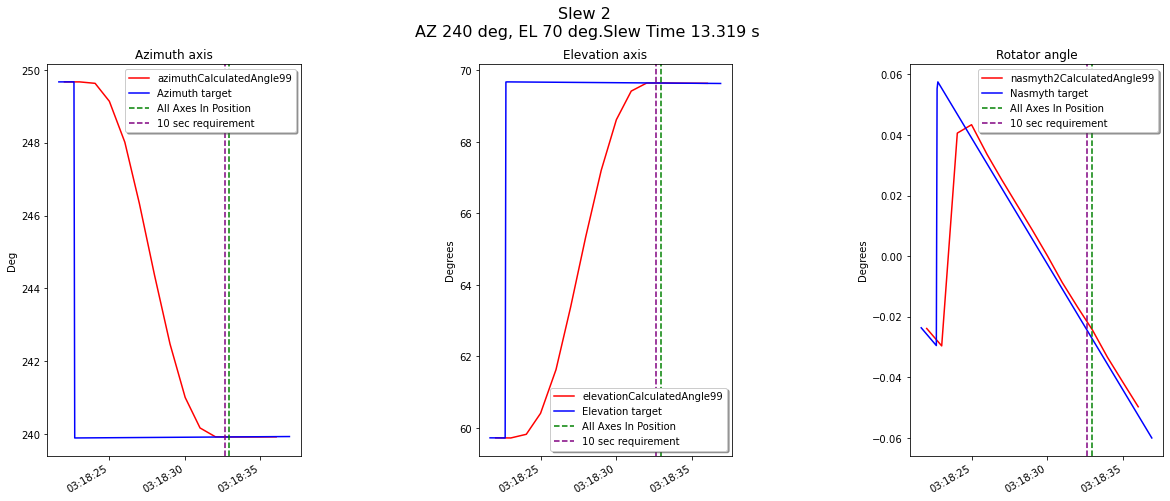

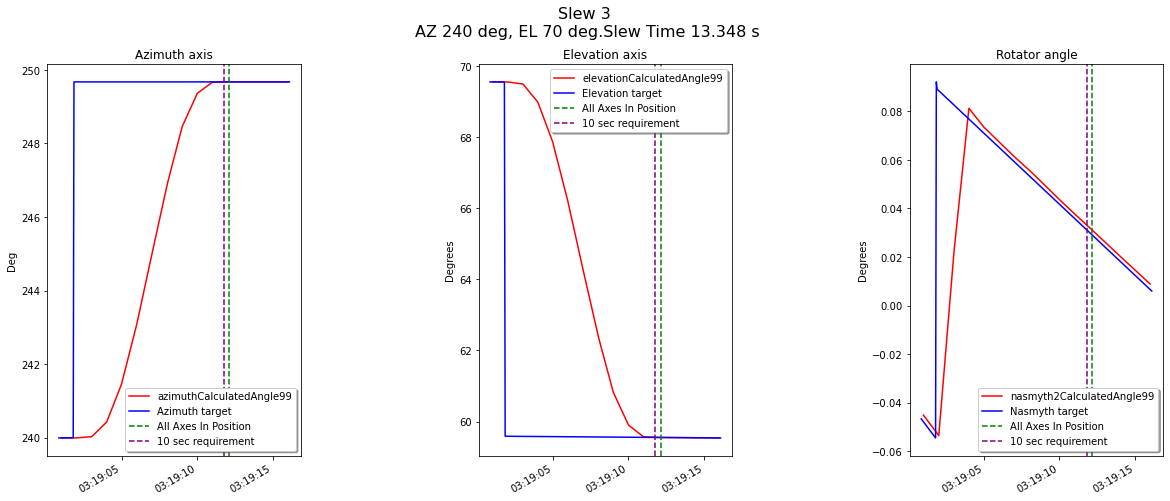

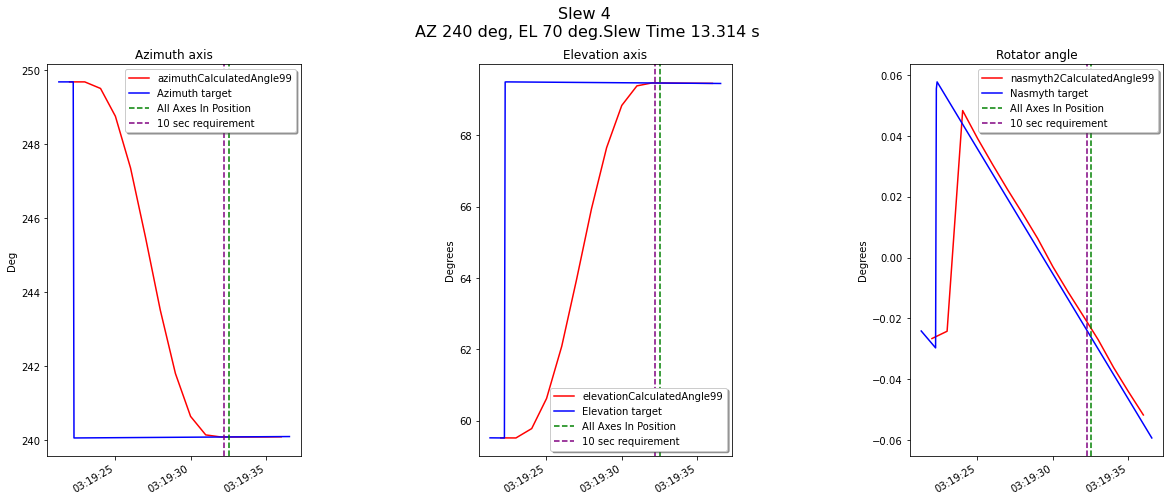

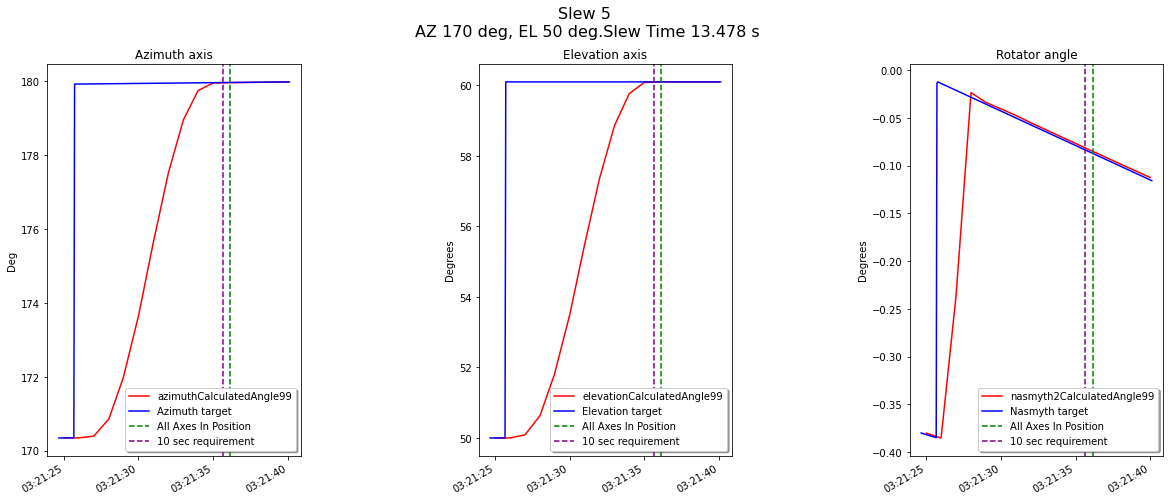

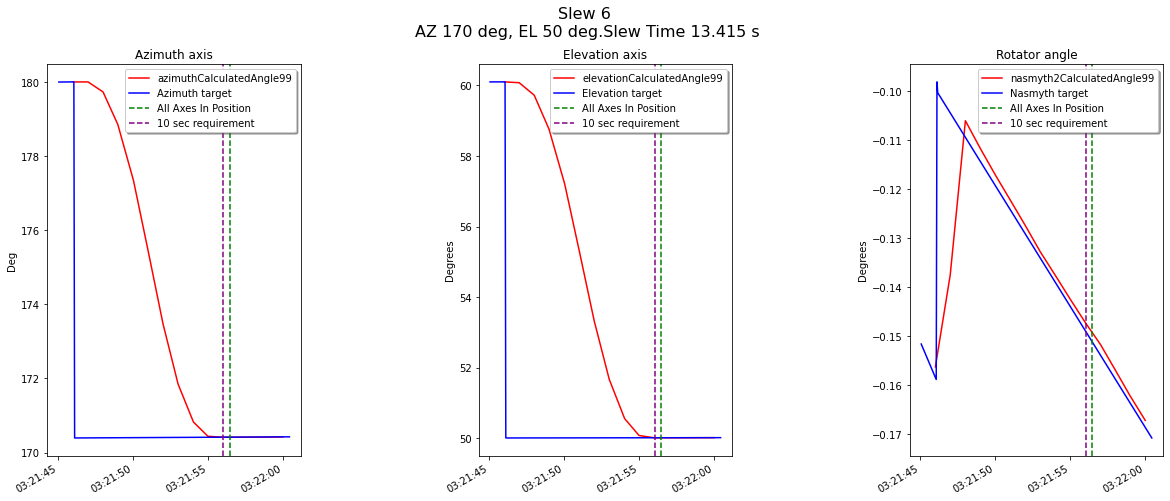

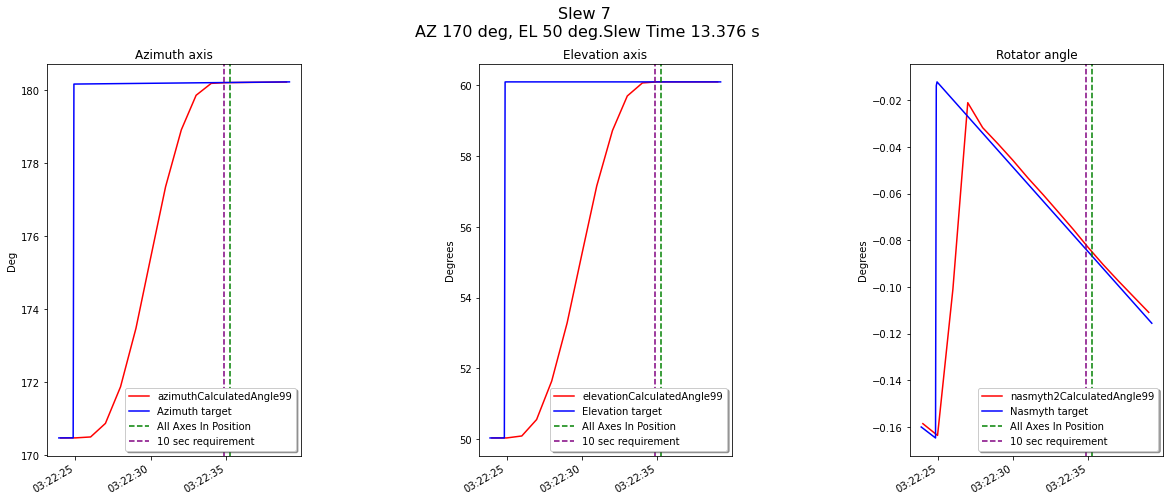

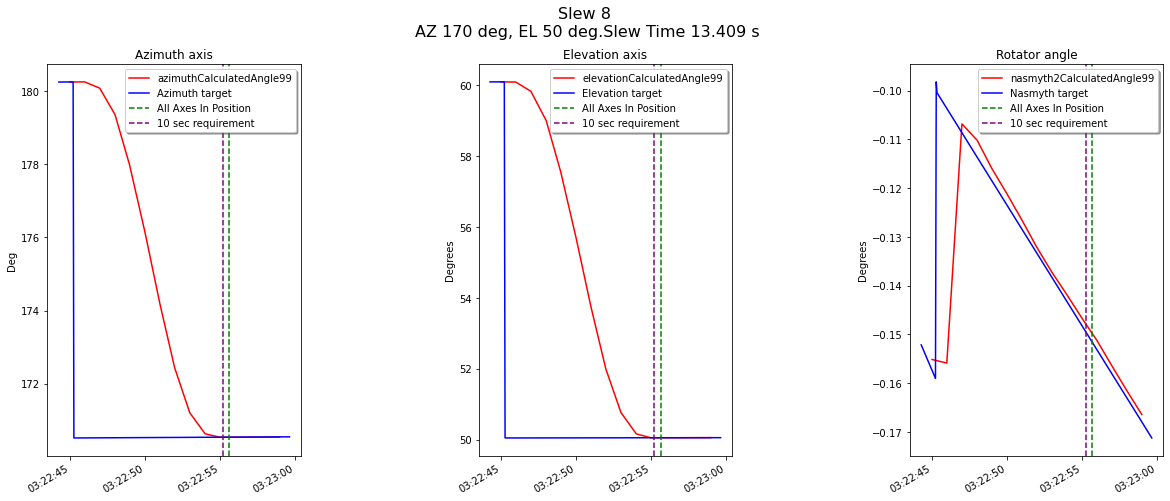

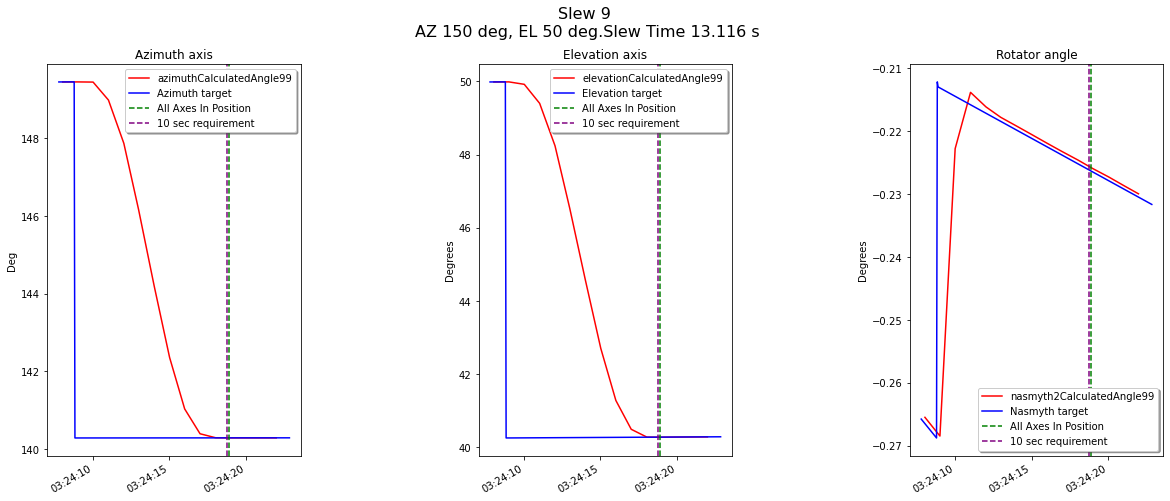

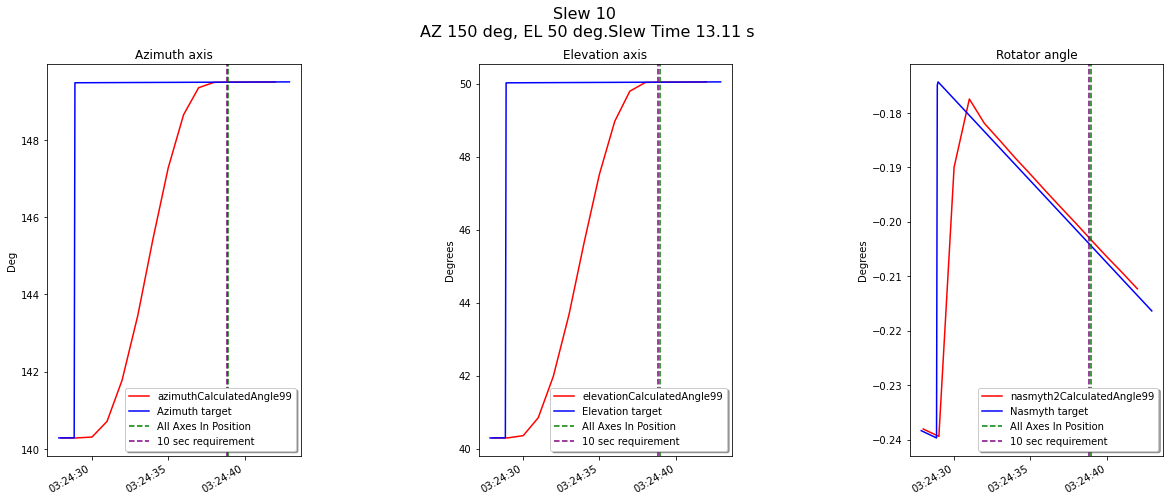

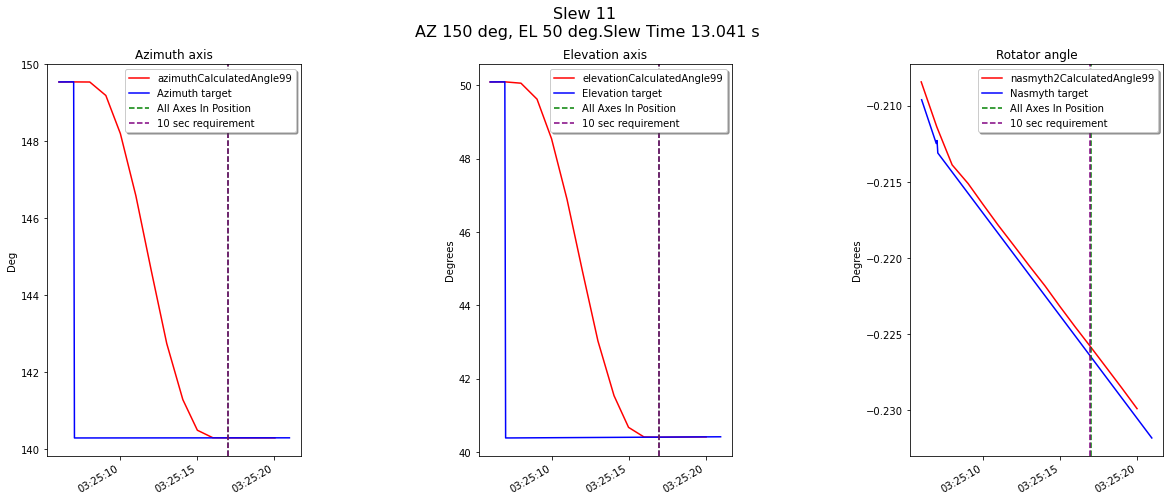

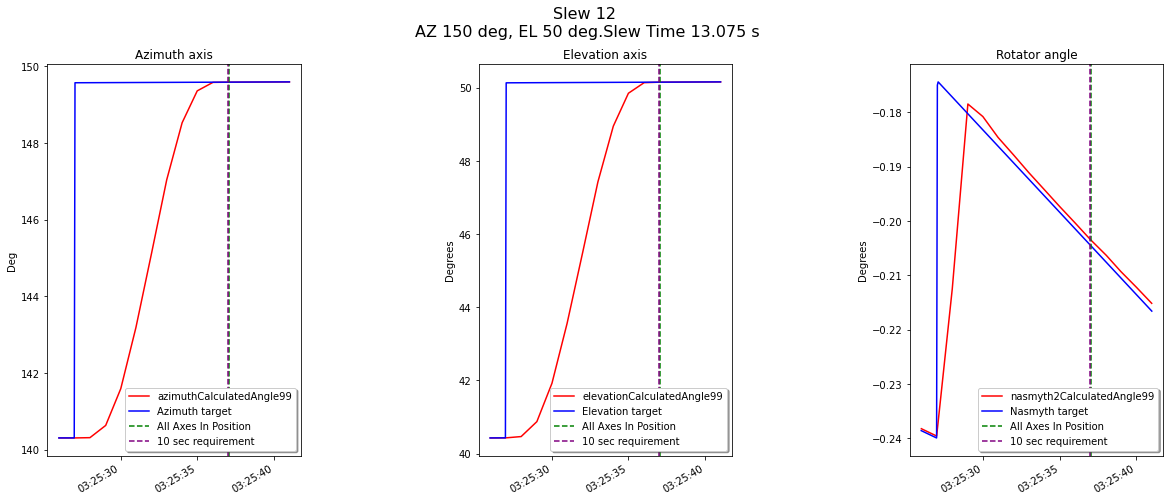

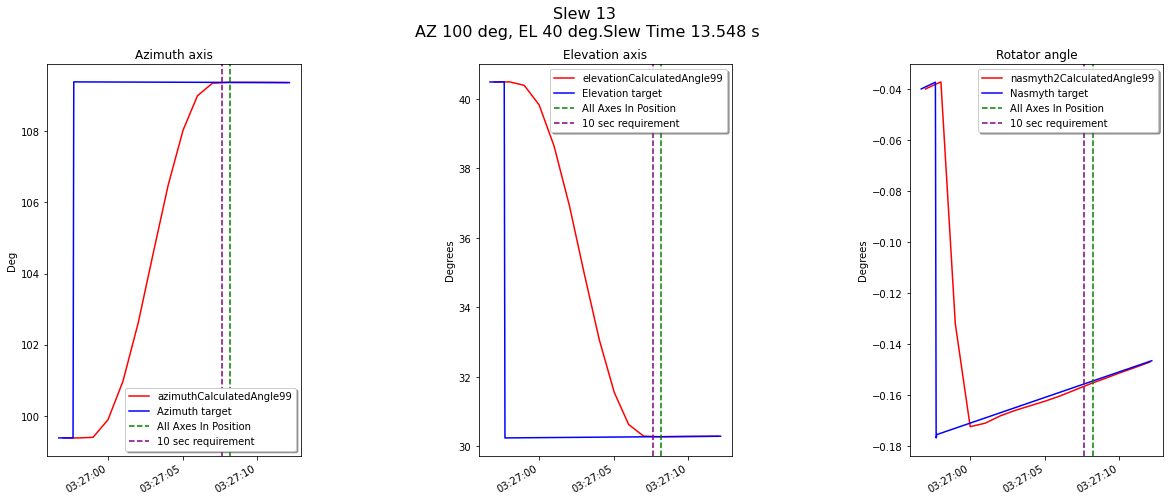

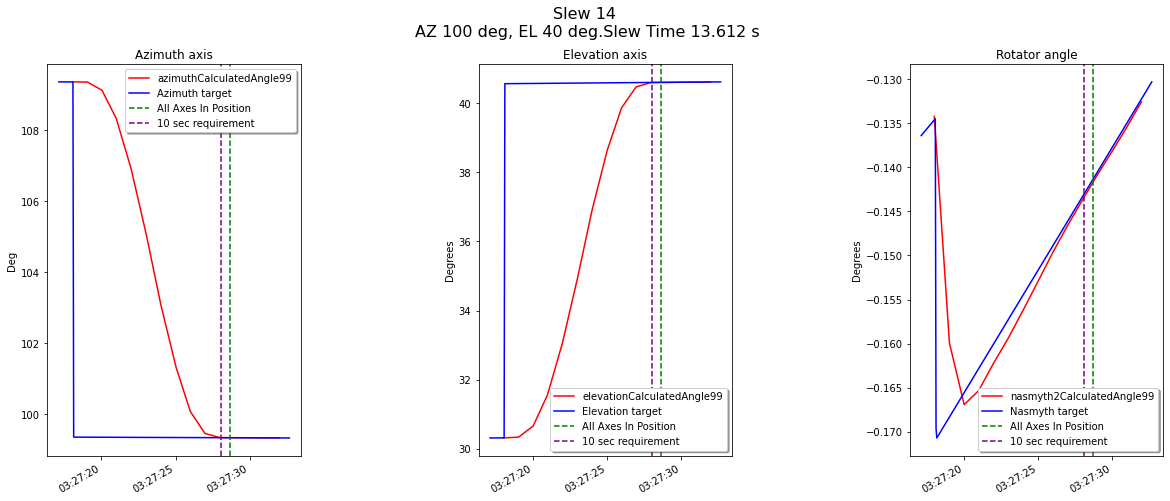

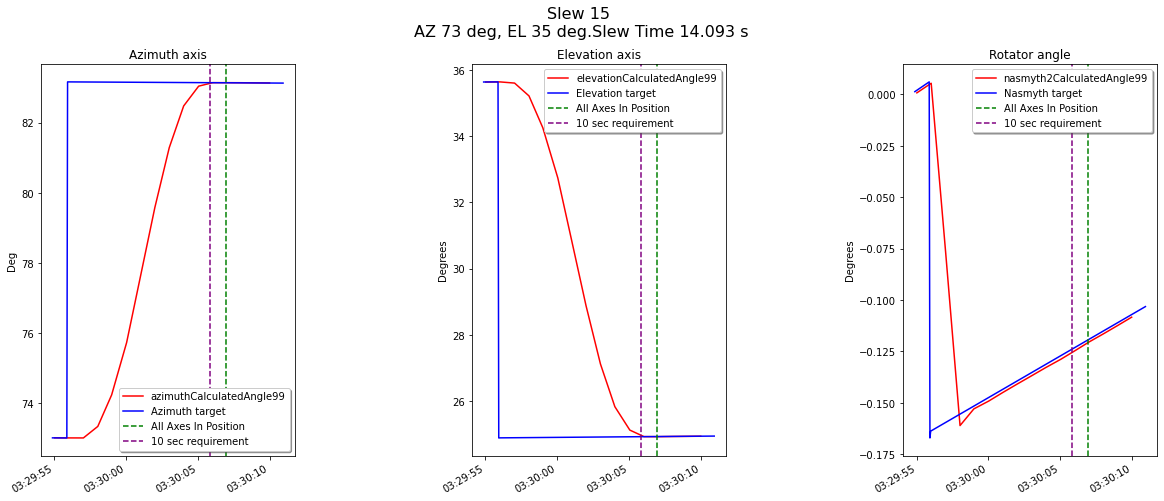

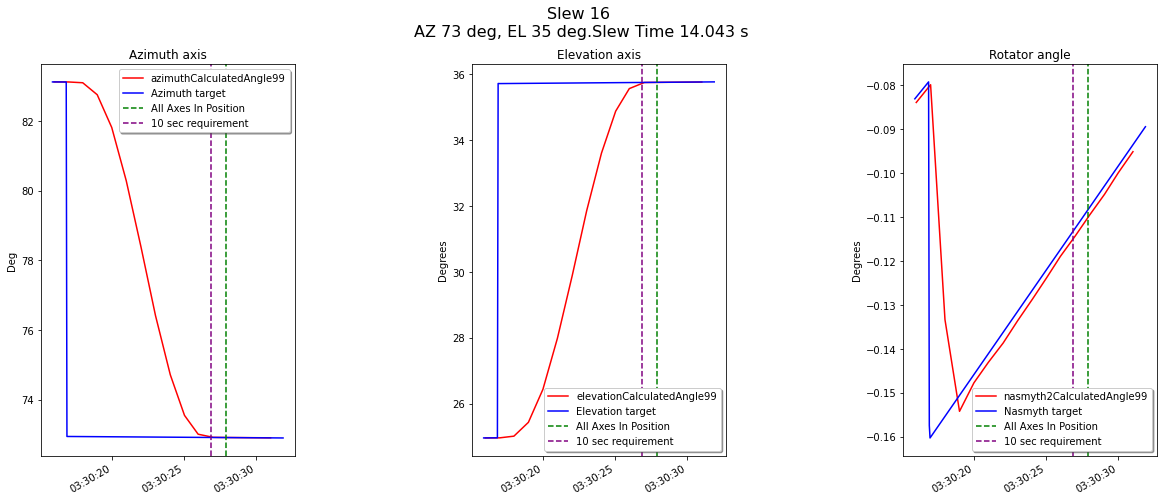

In [9]:
for i in range(len(df)):
    before, after = 1, 1
    t_start = Time(df['Start_Time[UTC]'][i],scale='utc') - TimeDelta(before, format='sec')
    t_end = Time(df['End_Time[UTC]'][i],scale='utc') + TimeDelta(after, format='sec')

    
    # Query EFD to get rotator azimuth, elevation mount positions and target coordinates
    mount = await client.select_time_series("lsst.sal.ATPtg.mountPositions", 
        ["azimuthCalculatedAngle99", "elevationCalculatedAngle99"], 
                                            t_start, t_end)
    target = await client.select_time_series("lsst.sal.ATMCS.command_trackTarget", 
                                            ["azimuth","elevation", "nasmyth2RotatorAngle"],  
                                             t_start, t_end)
    
    nasmyth = await client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders", 
                                              ['nasmyth2CalculatedAngle99'],
                                              t_start, t_end)

    # Find all axes in position
    all_axes_in_position = await client.select_time_series(
      'lsst.sal.ATMCS.logevent_allAxesInPosition', ['inPosition'],t_start, t_end)
    inPosition = all_axes_in_position[all_axes_in_position['inPosition']==True] 
    
    # Requirement
    requirement = (Time(df['Start_Time[UTC]'][i],scale='utc') + TimeDelta(
         10, format='sec')).datetime64  
    azimuth = (df['Start_Azimuth[deg]'][i])
    elevation = (df['Start_Elevation[deg]'][i])
    time = df['Slew_time[s]'][i]
    # Plot it
    fig = plt.figure(figsize = (20,8))
    plt.subplots_adjust(wspace=0.7)
    plt.suptitle(f'Slew {i+1} \n'
                  f'AZ {azimuth} deg, EL {elevation} deg.' 
                  f'Slew Time {time} s', 
                  fontsize = 16)
    # Azimuth axis
    plt.subplot(1,3,1)
    ax1 = mount['azimuthCalculatedAngle99'].plot(color='red')
    ax1.plot(target.index, target["azimuth"], label='Azimuth target', 
             color='blue')
    ax1.set_title("Azimuth axis", fontsize=12)
    ax1.axvline(inPosition.index[0], color="green", linestyle="--", 
                label="All Axes In Position")
    ax1.axvline(requirement, 
                color="purple", 
                linestyle="--", 
                label="10 sec requirement")   
    ax1.set_ylabel("Deg")
    ax1.legend(ncol=1, fancybox=True, shadow=True)    

    plt.subplot(1,3,2)
    ax2 = mount['elevationCalculatedAngle99'].plot(legend=False, color='red')
    ax2.plot(target.index, target["elevation"],
             label='Elevation target', color='blue')
    ax2.set_title("Elevation axis", fontsize=12)
    
    ax2.axvline(inPosition.index[0], color="green", l
                inestyle="--", label="All Axes In Position")
    ax2.axvline(requirement, 
                color="purple", 
                linestyle="--", 
                label="10 sec requirement")
    ax2.set_ylabel("Degrees")
    ax2.legend(ncol=1, fancybox=True, shadow=True)    
    
    # Nasmyth
    plt.subplot(1,3,3)
    ax3 = nasmyth['nasmyth2CalculatedAngle99'].plot(legend=False, color='red')
    ax3.plot(target.index, target["nasmyth2RotatorAngle"],
             label='Nasmyth target', color='blue')
    ax3.set_title("Rotator angle", fontsize=12)
    ax3.axvline(inPosition.index[0], color="green", 
                linestyle="--", label="All Axes In Position")
    ax3.axvline(requirement, 
                color="purple", 
                linestyle="--", 
                label="10 sec requirement")
    ax3.set_ylabel("Degrees")
    ax3.legend(
          ncol=1, fancybox=True, shadow=True)
    plt.show()

In [13]:
t_start = Time('2022-05-24T23:00:00', scale = 'utc')
t_end = Time('2022-05-25T23:15:00', scale='utc')

In [17]:
all_axes_in_position = await client.select_time_series(
  'lsst.sal.ATMCS.logevent_allAxesInPosition', ['inPosition'],t_start, t_end)
inPosition = all_axes_in_position[all_axes_in_position['inPosition']==True] 
inPosition


,inPosition
2022-05-24 23:15:58.004000+00:00,True
2022-05-24 23:43:04.874000+00:00,True
2022-05-24 23:51:00.521000+00:00,True
2022-05-24 23:51:26.122000+00:00,True
2022-05-24 23:57:32.626000+00:00,True
2022-05-24 23:57:38.624000+00:00,True
2022-05-24 23:57:41.323000+00:00,True
2022-05-24 23:58:29.176000+00:00,True
2022-05-24 23:58:34.824000+00:00,True
2022-05-24 23:58:45.381000+00:00,True


NameError: name 'i' is not defined

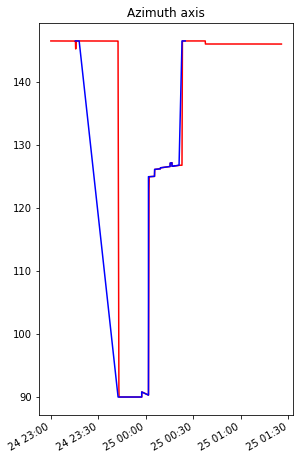

In [20]:
# t_start = Time(df['Start_Time[UTC]'][i],scale='utc') - TimeDelta(before, format='sec')
# t_end = Time(df['End_Time[UTC]'][i],scale='utc') + TimeDelta(after, format='sec')

    
# Query EFD to get rotator azimuth, elevation mount positions and target coordinates
mount = await client.select_time_series("lsst.sal.ATPtg.mountPositions", 
    ["azimuthCalculatedAngle99", "elevationCalculatedAngle99"], 
                                        t_start, t_end)
target = await client.select_time_series("lsst.sal.ATMCS.command_trackTarget", 
                                        ["azimuth","elevation", "nasmyth2RotatorAngle"],  
                                         t_start, t_end)

nasmyth = await client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders", 
                                          ['nasmyth2CalculatedAngle99'],
                                          t_start, t_end)

# Find all axes in position
all_axes_in_position = await client.select_time_series(
  'lsst.sal.ATMCS.logevent_allAxesInPosition', ['inPosition'],t_start, t_end)
inPosition = all_axes_in_position[all_axes_in_position['inPosition']==True] 

# Requirement
# requirement = (Time(df['Start_Time[UTC]'][i],scale='utc') + TimeDelta(
#      10, format='sec')).datetime64  
# azimuth = (df['Start_Azimuth[deg]'][i])
# elevation = (df['Start_Elevation[deg]'][i])
# time = df['Slew_time[s]'][i]
# Plot it
fig = plt.figure(figsize = (20,8))
plt.subplots_adjust(wspace=0.7)
# plt.suptitle(f'Slew {i+1} \n'
#               f'AZ {azimuth} deg, EL {elevation} deg.' 
#               f'Slew Time {time} s', 
#               fontsize = 16)
# Azimuth axis
plt.subplot(1,3,1)
ax1 = mount['azimuthCalculatedAngle99'].plot(color='red')
ax1.plot(target.index, target["azimuth"], label='Azimuth target', 
         color='blue')
ax1.set_title("Azimuth axis", fontsize=12)
ax1.vlines(inPosition, color="green", linestyle="--", 
            label="All Axes In Position")
# ax1.axvline(requirement, 
#             color="purple", 
#             linestyle="--", 
#             label="10 sec requirement")   
ax1.set_ylabel("Deg")
ax1.legend(ncol=1, fancybox=True, shadow=True)    

plt.subplot(1,3,2)
ax2 = mount['elevationCalculatedAngle99'].plot(legend=False, color='red')
ax2.plot(target.index, target["elevation"],
         label='Elevation target', color='blue')
ax2.set_title("Elevation axis", fontsize=12)

# ax2.axvline(inPosition.index, color="green", 
#             linestyle="--", label="All Axes In Position")
# # ax2.axvline(requirement, 
#             color="purple", 
#             linestyle="--", 
#             label="10 sec requirement")
ax2.set_ylabel("Degrees")
ax2.legend(ncol=1, fancybox=True, shadow=True)    

# Nasmyth
plt.subplot(1,3,3)
ax3 = nasmyth['nasmyth2CalculatedAngle99'].plot(legend=False, color='red')
ax3.plot(target.index, target["nasmyth2RotatorAngle"],
         label='Nasmyth target', color='blue')
ax3.set_title("Rotator angle", fontsize=12)
# ax3.axvline(inPosition.index, color="green", 
#             linestyle="--", label="All Axes In Position")
# # ax3.axvline(requirement, 
#             color="purple", 
#             linestyle="--", 
#             label="10 sec requirement")
ax3.set_ylabel("Degrees")
ax3.legend(
      ncol=1, fancybox=True, shadow=True)
plt.show()

## Pointing Accuracy

In [103]:
# In this part the pointing of the images will be measured and compared to 
# determine the pointing accuracy after a slew. 

In [13]:
from lsst.pipe.tasks.quickFrameMeasurement import QuickFrameMeasurementTask
from lsst.rapid.analysis.bestEffort import BestEffortIsr
import lsst.daf.butler as dafButler
from lsst.geom import PointD







/home/isotuela/auto-op-env-packages/rapid_analysis/python/lsst/rapid/analysis/visitCheck.py:132: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def runDataRef(self, dataRef):


In [14]:
# Call butler
REPO_DIR = '/repo/LATISS'
butler = dafButler.Butler(REPO_DIR, instrument='LATISS', collections = 'LATISS/raw/all')

In [15]:
# BestEffort ISR
bestEffort = BestEffortIsr('/repo/LATISS')

# Configure quickFrameMeasurement Task
qm_config = QuickFrameMeasurementTask.ConfigClass()
qm = QuickFrameMeasurementTask(config=qm_config)

Instantiating butler with collections=['u/czw/DM-28920/calib.20210720', 'LATISS/raw/all', 'LATISS/calib', 'LATISS/runs/quickLook']


In [16]:
def calculate_xy_offsets(exp):
    pixel_scale = 0.09569  # arcsec/pixel
    boresight_position = PointD(2036.5, 2000.5)

    """Returns x/y offset in arcseconds from an exp based on current centroid
    and desired position (which is the boresight position in pixels)"""

    data_id = {'instrument': 'LATISS', 'exposure': exp , 'detector':0}

    exp_BestEffort = bestEffort.getExposure(data_id)

    #Measure Centroids
    result = qm.run(exp_BestEffort)
    centroids = PointD(result.brightestObjCentroid[0], result.brightestObjCentroid[1])


    dx_arcsec, dy_arcsec = pixel_scale * (
        centroids - boresight_position
    )

    dr_arcsec = np.sqrt(dx_arcsec**2 + dy_arcsec**2)

    return dx_arcsec, dy_arcsec, dr_arcsec

In [17]:
# Measure x, y and r pointing error in origin and target images for each slew test.
pointing_origin, pointing_target = [], []
dx_origin, dx_target, dy_origin, dy_target = [], [], [], [] 

for i in range(len(df)):
    exp_origin = int(df['Start_image'][i][1:-1])
    
    dx, dy, dr = calculate_xy_offsets(exp_origin)
    
    dx_origin.append(dx)    
    dy_origin.append(dy)
    pointing_origin.append(dr)
    
    exp_target = int(df['End_image'][i][1:-1])
    dx, dy, dr = calculate_xy_offsets(exp_target)

    dx_target.append(dx)    
    dy_target.append(dy)
    pointing_target.append(dr)
    
df['Pointing_Origin[arcsec]'] = pointing_origin
df['dx_origin'] = dx_origin
df['dy_origin'] = dy_origin

df['Pointing_Target[arcssec]'] = pointing_target
df['dx_target'] = dx_target
df['dy_target'] = dy_target

Found a ready-made quickLookExp in the repo. Returning that.


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gd21d4de61c+48a4851ccd/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gd21d4de61c+48a4851ccd/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


Found 27 sources in exposure


Measured 27 of 27 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 19 sources in exposure


Measured 19 of 19 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 19 sources in exposure


Measured 19 of 19 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 23 sources in exposure


Measured 23 of 23 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 16 sources in exposure


Measured 16 of 16 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 17 sources in exposure


Measured 17 of 17 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 17 sources in exposure


Measured 17 of 17 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 11 sources in exposure


Measured 11 of 11 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 87 sources in exposure


Measured 87 of 87 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 123 sources in exposure


Measured 123 of 123 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 123 sources in exposure


Measured 123 of 123 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 98 sources in exposure


Measured 98 of 98 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 74 sources in exposure


Measured 74 of 74 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 114 sources in exposure


Measured 114 of 114 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 114 sources in exposure


Measured 114 of 114 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 96 sources in exposure


Measured 96 of 96 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 85 sources in exposure


Measured 85 of 85 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 130 sources in exposure


Measured 130 of 130 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 130 sources in exposure


Measured 130 of 130 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 96 sources in exposure


Measured 96 of 96 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 103 sources in exposure


Measured 103 of 103 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 147 sources in exposure


Measured 147 of 147 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 147 sources in exposure


Measured 147 of 147 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 122 sources in exposure


Measured 122 of 122 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 18 sources in exposure


Measured 18 of 18 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 34 sources in exposure


Measured 34 of 34 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 34 sources in exposure


Measured 34 of 34 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 18 sources in exposure


Measured 18 of 18 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 10 sources in exposure


Measured 10 of 10 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 19 sources in exposure


Measured 19 of 19 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 19 sources in exposure


Measured 19 of 19 sources in exposure


Found a ready-made quickLookExp in the repo. Returning that.


Found 15 sources in exposure


Measured 15 of 15 sources in exposure


In [18]:
# Calculate the relative pointing difference between origin and target centroids position or pointing accuracy after each slew. 
df['Relative_Pointing[arcsec]'] = np.sqrt((df['dx_target']-df['dx_origin'])**2 + 
                                          (df['dy_target']-df['dy_origin'])**2)
df

,Start_Time[UTC],End_Time[UTC],Start_Azimuth[deg],Start_Elevation[deg],Slew_Time[s],Start_image,End_image,Pointing_Origin[arcsec],dx_origin,dy_origin,Pointing_Target[arcssec],dx_target,dy_target,Relative_Pointing[arcsec]
0,2022-04-08T03:18:02.303,2022-04-08T03:18:15.651,240,70,13.348,[2022040700286],[2022040700287],6.710416,-6.120544,-2.751111,2.708837,2.690922,-0.311024,9.143084
1,2022-04-08T03:18:22.629,2022-04-08T03:18:35.948,240,70,13.319,[2022040700287],[2022040700288],2.708837,2.690922,-0.311024,6.645425,-6.094257,-2.649851,9.091176
2,2022-04-08T03:19:01.801,2022-04-08T03:19:15.149,240,70,13.348,[2022040700289],[2022040700290],6.623699,-5.977018,-2.854584,2.871998,2.824783,-0.518627,9.106503
3,2022-04-08T03:19:22.231,2022-04-08T03:19:35.545,240,70,13.314,[2022040700290],[2022040700291],2.871998,2.824783,-0.518627,6.371537,-5.821717,-2.589225,8.890970
4,2022-04-08T03:21:25.666,2022-04-08T03:21:39.144,170,50,13.478,[2022040700292],[2022040700293],4.689285,-4.244020,1.994412,5.532261,-5.513196,-0.458888,2.762153
5,2022-04-08T03:21:46.030,2022-04-08T03:21:59.446,170,50,13.415,[2022040700293],[2022040700294],5.532261,-5.513196,-0.458888,4.406367,-3.988180,1.873631,2.786811
6,2022-04-08T03:22:24.872,2022-04-08T03:22:38.248,170,50,13.376,[2022040700295],[2022040700296],4.319704,-4.111268,1.325638,5.462332,-5.454157,-0.298742,2.107595
7,2022-04-08T03:22:45.241,2022-04-08T03:22:58.651,170,50,13.409,[2022040700296],[2022040700297],5.462332,-5.454157,-0.298742,4.722085,-4.245341,2.067646,2.657260
8,2022-04-08T03:24:08.780,2022-04-08T03:24:21.896,150,50,13.116,[2022040700298],[2022040700299],2.876835,-2.595282,1.241246,5.358740,-4.708547,2.558452,2.490165
9,2022-04-08T03:24:28.838,2022-04-08T03:24:41.948,150,50,13.110,[2022040700299],[2022040700300],5.358740,-4.708547,2.558452,1.058291,-0.091521,-1.054326,5.862516


***

In [19]:
# Calculate pointing accuracy RMS. 
rms = np.sqrt(((df['Relative_Pointing[arcsec]']**2).sum())/len(df))
print(f'The pointing accuracy RMS for the analyzed small slew and settle tests is {rms:0.2f} arcsec')

The pointing accuracy RMS for the analyzed small slew and settle tests is 10.02 arcsec


***

# 4. Conclusions

***

The slew acquisition time is larger (13.2 +- 0.2 sec) than the 10 seconds requirement in the 16 slew test cases considered, originating in different parts of the pointing range. 

The pointing accuracy RMS obtained from the images taken at the origin and final positions of the slew does not meet the 2.5 arcsec requirement specified in LTS-337-015 (Small Slew and Settle). 

***